In [ ]:
!pip install mne

import scipy.io as spio
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import mne
from mne.io import RawArray
from mne import create_info
from mne.channels import make_standard_montage

path_data = 'MyDrive/Colab Notebooks/data'
path_mount = '/content/drive/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount(path_mount)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data loading

In [ ]:
subjects = ["S1", "S2", "S3", "S4", "S5"]
unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]
subject = "S5"

data = mne.io.read_raw_fif(f'{path_mount}/{path_data}'+'/S5_eeg.fif')

#sample_data_folder = mne.datasets.sample.data_path()
#sample_data_raw_file = os.path.join(,'S1_eeg.fif')
#raw = mne.io.read_raw_fif(sample_data_raw_file)


#file_path = os.path.join(path_mount, path_data, "json", subject)
#df = pd.read_json(file_path + ".json")
#trigger = np.array(df.trigger)

#eeg = df[unicorn_channels].to_numpy()
#chs = unicorn_channels
#fs = df['sampling_rate'].values[0]

Opening raw data file /content/drive//MyDrive/Colab Notebooks/data/S5_eeg.fif...
    Range : 0 ... 60854 =      0.000 ...   243.416 secs
Ready.


In [ ]:
data.ch_names

['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8', 'STI']

1200 events found
Event IDs: [1 3]


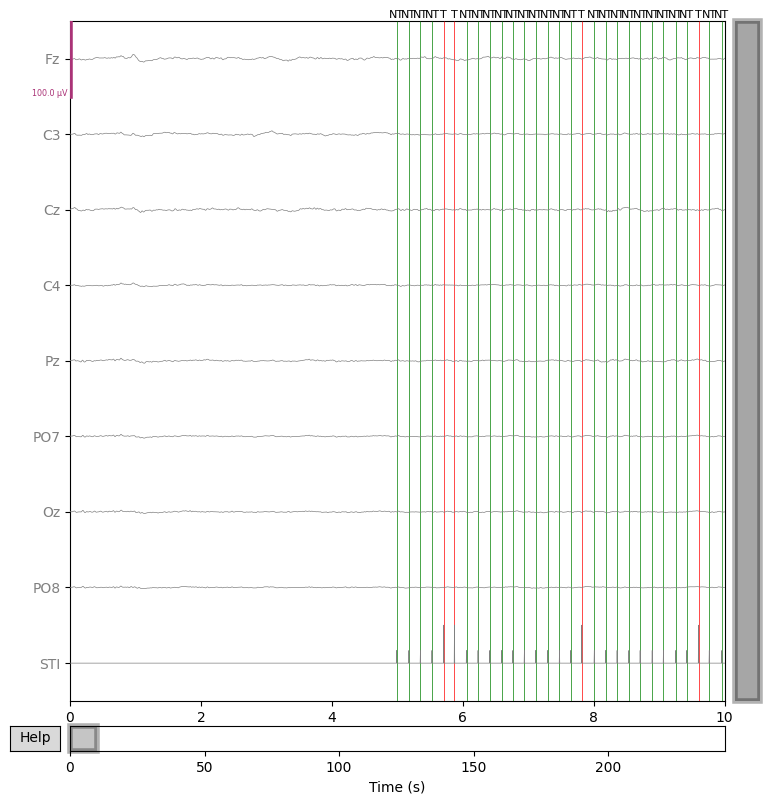

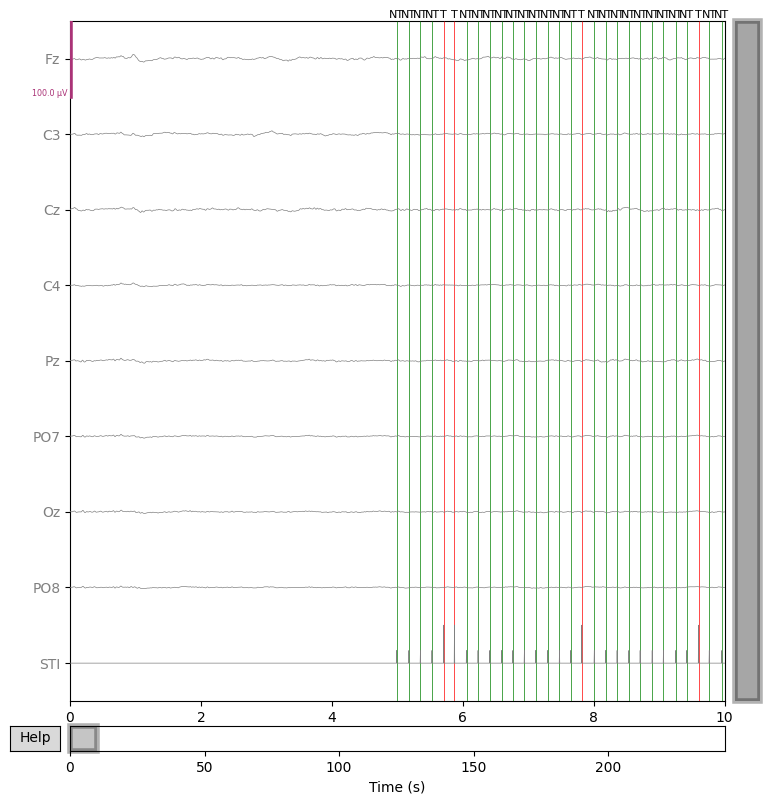

In [ ]:
from mne import find_events


# extracting events from the stimuli channel and giving thema a class name with the dict ev_ids
evs = find_events(data, stim_channel='STI')
ev_ids = {'NT': 1, 'T': 3}

# Easily visualize events along the signal plot
data.plot(events = evs, event_id = ev_ids, event_color ={1:'g',3:'r'}, color = 'Gray',
             block = True, clipping=None, scalings=50e-6)

In [ ]:
obj=  ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8", "STI"]
df= data[obj][0]

In [ ]:
from mne import Epochs
eps = Epochs(data, evs, event_id=ev_ids, 
             tmin=-.6, tmax=0.8, baseline=(-.6,-.1)) 

Not setting metadata
1200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [ ]:
epochs_target = eps
e = epochs_target.to_data_frame()
e = e.drop(e[e['time'] < .2].index)
e = e.drop(e[e['time'] > .65].index)

e.loc[e['condition'] == 'NT', 'condition'] = 1
e.loc[e['condition'] == 'T', 'condition'] = 0

e['condition'] = e['condition'].astype(int)

y= e['condition']
y=y.values
x = e.drop(['condition'], axis = 1)
x=x.drop(['STI'],axis=1)
x=x.drop(['time'],axis=1)
n = 1200
Y = []
X = []
for i in range(n):
    X.append(x[x['epoch'] == i])
    X[-1]=X[-1].drop(['epoch'], axis = 1)
    X[-1]=X[-1].T
    X[-1]=X[-1].values
    X[-1]=[X[-1]]

for i in range(n):
    if y[113*i]==0:
      Y.append(0)
    if y[113*i]!=0:
      Y.append(1)

  

Loading data for 1200 events and 351 original time points ...
0 bad epochs dropped


In [ ]:
dataframe=pd.DataFrame(df.T, columns=obj)
dataframe

,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,STI
0,-1.058791e-22,1.058791e-22,2.117582e-22,-4.764560e-22,1.852885e-22,-5.293956e-23,-1.588187e-22,-5.293956e-23,0.0
1,-1.081623e-07,6.169030e-08,3.497122e-07,-6.489834e-08,2.351446e-07,1.981680e-07,1.738159e-07,1.257642e-07,0.0
2,-2.466018e-07,5.437604e-08,6.537576e-07,-1.158242e-07,4.062307e-07,3.315085e-07,2.922208e-07,2.021575e-07,0.0
3,-4.277910e-07,-4.914565e-08,8.834830e-07,-1.450097e-07,4.792169e-07,3.655086e-07,3.218862e-07,2.034835e-07,0.0
4,-6.379939e-07,-2.167846e-07,1.036136e-06,-1.544177e-07,4.646803e-07,3.113151e-07,2.643916e-07,1.400851e-07,0.0
...,...,...,...,...,...,...,...,...,...
60850,1.001250e-07,-1.665932e-07,-4.074592e-07,-1.706138e-07,-3.672838e-07,-2.692201e-07,-3.984325e-07,2.774240e-08,0.0
60851,-1.327144e-07,-3.403854e-07,-4.504165e-07,-2.228234e-07,-4.476307e-07,-4.028786e-07,-5.853505e-07,-7.063175e-08,0.0
60852,-2.203373e-07,-3.595885e-07,-4.060719e-07,-2.151719e-07,-3.978347e-07,-3.851996e-07,-5.524165e-07,-1.013497e-07,0.0
60853,-1.573699e-07,-2.264806e-07,-2.439131e-07,-1.325714e-07,-2.325712e-07,-2.322602e-07,-3.304964e-07,-6.940758e-08,0.0


In [ ]:
eps.to_data_frame()

Loading data for 1200 events and 351 original time points ...


,time,condition,epoch,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,STI
0,-0.600,NT,0,-2.024414,-2.849253,-1.389251,-0.964638,-0.875577,-1.022816,-0.814252,-0.423604,0.0
1,-0.596,NT,0,-1.967660,-2.902610,-1.475077,-0.996299,-0.973547,-1.146362,-0.984234,-0.511960,0.0
2,-0.592,NT,0,-1.778573,-2.845032,-1.425766,-0.879936,-0.948601,-1.169433,-1.067522,-0.525240,0.0
3,-0.588,NT,0,-1.474382,-2.680954,-1.274248,-0.650404,-0.820765,-1.094171,-1.054265,-0.460555,0.0
4,-0.584,NT,0,-1.101122,-2.434434,-1.094386,-0.370408,-0.648418,-0.959163,-0.976886,-0.342005,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
421195,0.784,NT,1199,-0.674936,-3.022238,-0.368531,-0.719248,0.499368,0.166400,0.271827,0.951379,0.0
421196,0.788,NT,1199,-0.953955,-2.554005,-0.493267,-1.498570,0.279566,0.081182,0.021071,0.824780,0.0
421197,0.792,NT,1199,-1.129637,-2.140500,-0.575300,-2.067523,0.019562,-0.046217,-0.256640,0.691786,0.0
421198,0.796,NT,1199,-1.161008,-1.776143,-0.587109,-2.316950,-0.216944,-0.158267,-0.472100,0.594942,0.0


# CNN

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class EEGNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(3584, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
            #nn.Linear(512,1)
            #,nn.Tanh()
            )
        
    def forward(self, xb):
        return self.network(xb)

### Train set e Test set

In [ ]:
torch.manual_seed(10)

In [ ]:
epochs=X
iris = TensorDataset(torch.FloatTensor(X),torch.LongTensor(Y))

In [ ]:
val_pct = 0.2
test_size = int(val_pct * len(epochs))
train_size = len(epochs) - test_size

In [ ]:
train_ds, test_ds = random_split(iris, [train_size, test_size])
len(train_ds), len(test_ds)

(960, 240)

In [ ]:
batch_size=60
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
signal, labels = next(iter(train_loader))
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)
signal1, labels1 = next(iter(test_loader))
classes=('0','1')

# Using cuda

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
model= EEGNET()

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
to_device(model, device);

In [ ]:
if torch.cuda.is_available():
  torch_device='cuda'
else:
  torch_device='cpu'

# Training phase

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
salva=[]
def train(epoch,net,optimizer,criterion):
    for epoch in tqdm(range(epoch)):  
        train_loss = 0
        correct_train = 0
        total_train = 0
        #count=0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs.to(torch_device))
            #if count==0:
             # print(np.shape(outputs),"\n", outputs,"\n",np.shape(labels), labels)
             # count+=1
            loss = criterion(outputs, labels.to(torch_device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels.to(torch_device)).cpu().sum().item()

        train_accuracy = 100 * correct_train / total_train
        print('Epoch %d, train loss: %.3f, train accuracy: %.2f%%' %
              (epoch + 1, train_loss / len(train_loader), train_accuracy))
        
    print('Finished Training')

In [ ]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images.to(torch_device))
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0) 
            correct += (predicted == labels.to(torch_device)).sum().item() 
    accuracy = 100 * correct / total  
    return accuracy

def accuracy_classes(net,dataloader,classes): 
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images.to(torch_device))
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels.to(torch_device), predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epoch=100

In [ ]:
pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary

summary(model, input_size=(60,1, 8, 351))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       18,496
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Flatten: 2-16                     --
|    └─Linear: 2-17                      3,671,040
|    └─ReLU: 2-18                        --
|    └─Linear: 2-19                      524,800
|    └─ReLU: 2-20                  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       18,496
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Flatten: 2-16                     --
|    └─Linear: 2-17                      3,671,040
|    └─ReLU: 2-18                        --
|    └─Linear: 2-19                      524,800
|    └─ReLU: 2-20                  

In [ ]:
train(epoch,model,optimizer,criterion)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, train loss: 30.112, train accuracy: 81.98%
Epoch 2, train loss: 23.599, train accuracy: 86.77%
Epoch 3, train loss: 23.555, train accuracy: 86.77%
Epoch 4, train loss: 23.678, train accuracy: 86.77%
Epoch 5, train loss: 22.732, train accuracy: 86.77%
Epoch 6, train loss: 20.029, train accuracy: 86.88%
Epoch 7, train loss: 16.816, train accuracy: 88.12%
Epoch 8, train loss: 14.656, train accuracy: 91.35%
Epoch 9, train loss: 14.938, train accuracy: 90.73%
Epoch 10, train loss: 10.680, train accuracy: 92.92%
Epoch 11, train loss: 9.578, train accuracy: 94.06%
Epoch 12, train loss: 9.232, train accuracy: 94.79%
Epoch 13, train loss: 7.444, train accuracy: 95.73%
Epoch 14, train loss: 6.832, train accuracy: 95.00%
Epoch 15, train loss: 5.495, train accuracy: 96.25%
Epoch 16, train loss: 4.589, train accuracy: 97.19%
Epoch 17, train loss: 6.943, train accuracy: 96.15%
Epoch 18, train loss: 3.886, train accuracy: 97.92%
Epoch 19, train loss: 1.632, train accuracy: 98.75%
Epoch 20, t

In [ ]:
evaluate_accuracy(model, test_loader)

94.58333333333333

In [ ]:
y_true = to_device(labels1, device)

for data in test_loader:
    s1, l1 = data
    outputs = model(s1.to(torch_device))
    #print(outputs)
    _, predictions = torch.max(outputs,1)
    #print(predictions)
    break

#outputs = to_device(labels1,'cpu')
#_, predicted = torch.max(outputs.data, 1) 
#pred=to_device(model(tree),'cpu')
#print(predictions==y_true)
#print(y_true)

In [ ]:
f1_score(y_true.cpu(),predictions.cpu())

0.9859154929577464